<div class="alert alert-block alert-info" style="font-size:20px; background-color: #fffcc7; font-family:verdana; color: #636135; border: 3px #636135 solid">
    <b>Simple GANs</b>
    <br>Vamos a ver un ejemplo de cómo generar una GAN sencilla<br>
</div>


<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Importamos librerías</b>
</div>


In [3]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/77/df/b56175c3fb5bc058774bdcf35f5a71cf9c3c5b909f98a1c688eb71cd3b1f/opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 9.0 MB/s eta 0:00:0000:0100:01


In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)

In [6]:
print(os.getcwd())
DATA_DIR = '/Users/n.c.rodriguez/nico/curso_AI/IA Generativa/GANs/cats/Cat'

/Users/n.c.rodriguez/nico/curso_AI/IA Generativa/GANs/cats


In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Prepare data
<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Preparación de los datos</b>
</div>


In [8]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Let's see what butch looks like</b>
</div>


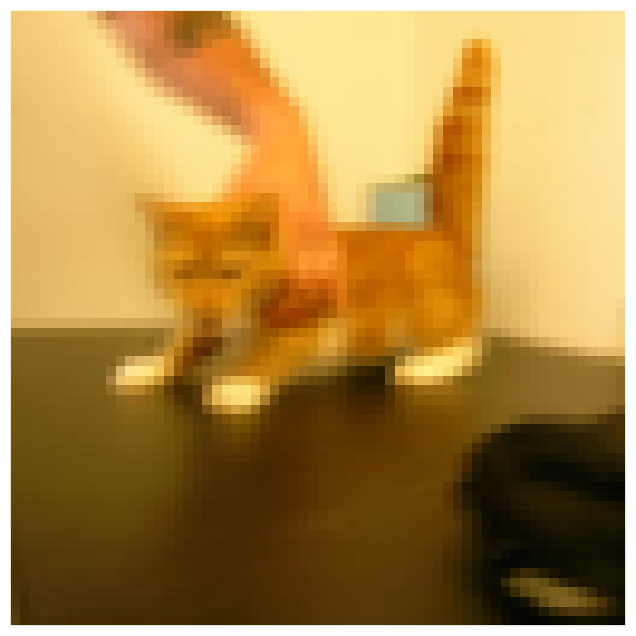

In [12]:
show_batch(train_dl)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Dataloader</b>
</div>


In [13]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [15]:
train_dl = DeviceDataLoader(train_dl, device)

# Model
<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Vamos directamente a la construcción de la GAN</b>
    <br>Recuerda que la GAN consta de dos redes: un generador cuya tarea es aprender a generar imágenes similares a una muestra de entrenamiento a partir de ruido aleatorio, y un discriminador que aprende a reconocer si esta imagen es real o generada por el generador.<br>

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid; padding:20px">
    Construyamos un generador y un discriminador sobre convoluciones:
</div>

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <p>A ver como es el ruido desde el que las imagenes serán generadas. </p>
    <p>Una GAN comienza con un ruido aleatorio y, a través de un proceso iterativo de aprendizaje entre dos redes (el generador y el discriminador), va modificando ese ruido. </p>
    <p>El generador intenta crear imágenes cada vez más parecidas a las reales, mientras que el discriminador evalúa si son reales o generadas. </p>
    <p>El proceso se repite hasta que el generador logra engañar al discriminador produciendo imágenes muy similares a las reales. </p>
    <p>Este proceso iterativo de mejora mutua entre generador y discriminador es lo que permite a la GAN aprender a generar imágenes que se asemejan a las del conjunto de entrenamiento.</p>
</div>

torch.Size([128, 3, 64, 64])


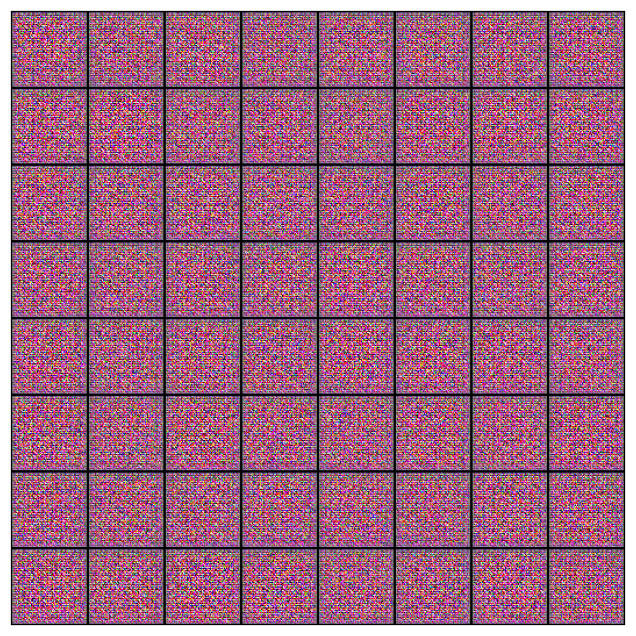

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid">
    <b>Ahora pasemos a enseñar a nuestra GAN. El algoritmo de aprendizaje es el siguiente:</b>
<ul>
    <li>Enseñamos al discriminador:
        <ul>
            <li>tomamos imágenes reales y les asignamos la etiqueta 1</li>
            <li>generamos imágenes con un generador y les asignamos una etiqueta 0</li>
            <li>entrenamos al clasificador en dos clases</li>
        </ul>
    </li>
    <li>Enseñamos al generador:
        <ul>
            <li>generamos imágenes con un generador y les asignamos una etiqueta 0</li>
            <li>predecimos con un discriminador si esta imagen es real o no</li>
        </ul>
    </li>
</ul>
</div>

**Como función de pérdida, tomamos la entropía cruzada binaria**


![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/c40/568/876/c40568876434c2bcc933c2a5b7d29725.jpeg)

In [25]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [26]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 55

In [27]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/55], loss_g: 1.5313, loss_d: 1.2573, real_score: 0.5913, fake_score: 0.5105


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/55], loss_g: 2.5236, loss_d: 1.2427, real_score: 1.0000, fake_score: 0.7012


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/55], loss_g: 3.7447, loss_d: 0.4470, real_score: 1.0000, fake_score: 0.3547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/55], loss_g: 4.1234, loss_d: 0.1850, real_score: 1.0000, fake_score: 0.1672


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/55], loss_g: 4.3873, loss_d: 0.1561, real_score: 1.0000, fake_score: 0.1430


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/55], loss_g: 4.7413, loss_d: 0.1329, real_score: 1.0000, fake_score: 0.1235


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/55], loss_g: 5.2903, loss_d: 0.0973, real_score: 1.0000, fake_score: 0.0918


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/55], loss_g: 5.4774, loss_d: 0.0542, real_score: 0.9999, fake_score: 0.0525


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/55], loss_g: 5.5642, loss_d: 0.0479, real_score: 0.9998, fake_score: 0.0464


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/55], loss_g: 5.7237, loss_d: 0.0458, real_score: 0.9997, fake_score: 0.0443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/55], loss_g: 6.1132, loss_d: 0.0517, real_score: 0.9995, fake_score: 0.0498


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/55], loss_g: 6.2501, loss_d: 0.0323, real_score: 0.9991, fake_score: 0.0309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/55], loss_g: 6.2058, loss_d: 0.0282, real_score: 0.9987, fake_score: 0.0265


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/55], loss_g: 6.1125, loss_d: 0.0264, real_score: 0.9983, fake_score: 0.0244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/55], loss_g: 6.2191, loss_d: 0.0264, real_score: 0.9981, fake_score: 0.0241


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/55], loss_g: 6.3264, loss_d: 0.0231, real_score: 0.9980, fake_score: 0.0208


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/55], loss_g: 6.2838, loss_d: 0.0201, real_score: 0.9980, fake_score: 0.0179


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/55], loss_g: 6.2383, loss_d: 0.0208, real_score: 0.9981, fake_score: 0.0187


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/55], loss_g: 6.3328, loss_d: 0.0188, real_score: 0.9983, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/55], loss_g: 6.4909, loss_d: 0.0175, real_score: 0.9984, fake_score: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/55], loss_g: 6.4100, loss_d: 0.0160, real_score: 0.9985, fake_score: 0.0144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/55], loss_g: 6.5504, loss_d: 0.0185, real_score: 0.9986, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/55], loss_g: 6.6150, loss_d: 0.0153, real_score: 0.9986, fake_score: 0.0137


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/55], loss_g: 6.5993, loss_d: 0.0121, real_score: 0.9986, fake_score: 0.0106


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/55], loss_g: 6.5264, loss_d: 0.0126, real_score: 0.9986, fake_score: 0.0111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/55], loss_g: 6.5172, loss_d: 0.0125, real_score: 0.9987, fake_score: 0.0111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/55], loss_g: 6.6216, loss_d: 0.0113, real_score: 0.9987, fake_score: 0.0099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/55], loss_g: 6.5570, loss_d: 0.0107, real_score: 0.9988, fake_score: 0.0094


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/55], loss_g: 6.5969, loss_d: 0.0103, real_score: 0.9988, fake_score: 0.0091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/55], loss_g: 6.5750, loss_d: 0.0101, real_score: 0.9989, fake_score: 0.0089


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/55], loss_g: 6.5722, loss_d: 0.0092, real_score: 0.9989, fake_score: 0.0081


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/55], loss_g: 6.5443, loss_d: 0.0094, real_score: 0.9989, fake_score: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/55], loss_g: 6.6820, loss_d: 0.0095, real_score: 0.9990, fake_score: 0.0084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/55], loss_g: 6.6538, loss_d: 0.0084, real_score: 0.9990, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/55], loss_g: 6.7251, loss_d: 0.0093, real_score: 0.9990, fake_score: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/55], loss_g: 6.7484, loss_d: 0.0096, real_score: 0.9990, fake_score: 0.0085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/55], loss_g: 6.7231, loss_d: 0.0081, real_score: 0.9990, fake_score: 0.0070


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/55], loss_g: 6.7421, loss_d: 0.0079, real_score: 0.9990, fake_score: 0.0068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/55], loss_g: 6.6387, loss_d: 0.0076, real_score: 0.9990, fake_score: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/55], loss_g: 6.6157, loss_d: 0.0080, real_score: 0.9990, fake_score: 0.0070


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/55], loss_g: 6.6986, loss_d: 0.0073, real_score: 0.9990, fake_score: 0.0064


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/55], loss_g: 6.6890, loss_d: 0.0071, real_score: 0.9991, fake_score: 0.0061


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/55], loss_g: 6.6769, loss_d: 0.0065, real_score: 0.9991, fake_score: 0.0055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/55], loss_g: 6.6280, loss_d: 0.0067, real_score: 0.9991, fake_score: 0.0058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/55], loss_g: 6.6560, loss_d: 0.0070, real_score: 0.9991, fake_score: 0.0061


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/55], loss_g: 6.7702, loss_d: 0.0068, real_score: 0.9991, fake_score: 0.0059


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/55], loss_g: 6.7593, loss_d: 0.0068, real_score: 0.9991, fake_score: 0.0059


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/55], loss_g: 6.8061, loss_d: 0.0064, real_score: 0.9991, fake_score: 0.0055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/55], loss_g: 6.7956, loss_d: 0.0067, real_score: 0.9991, fake_score: 0.0058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/55], loss_g: 6.7784, loss_d: 0.0063, real_score: 0.9991, fake_score: 0.0054


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/55], loss_g: 6.7837, loss_d: 0.0061, real_score: 0.9991, fake_score: 0.0052


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/55], loss_g: 6.7572, loss_d: 0.0061, real_score: 0.9991, fake_score: 0.0052


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/55], loss_g: 6.7451, loss_d: 0.0062, real_score: 0.9991, fake_score: 0.0053


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/55], loss_g: 6.6936, loss_d: 0.0077, real_score: 0.9991, fake_score: 0.0068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/55], loss_g: 6.7468, loss_d: 0.0077, real_score: 0.9991, fake_score: 0.0067
Saving generated-images-0055.png


# Predict
<div class="alert alert-block alert-info" style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid; padding: 20px">
    Veamos la salida del aprendizaje. Así es como se ven las imagenes generadas en la última época de entrenamiento:
</div>

In [28]:
losses_g, losses_d, real_scores, fake_scores = history

In [34]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

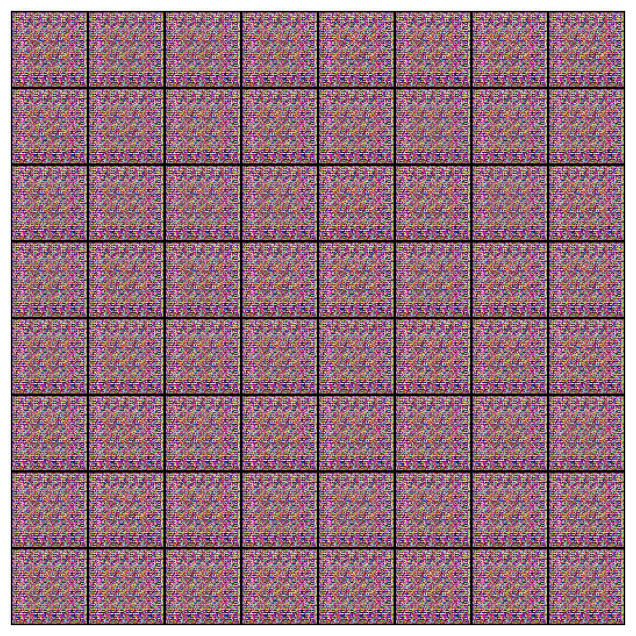

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

# Let's build grafs
<div style="font-size:20px; background-color: #435287; color: #ffffff; border: 1px #ffffff solid; padding:20px">
    La imagenes son similares a la muestra pero hay bastantes artefactos
    <br>Let's look at the graphs of the loss generator and discriminator and score discriminator<br>
</div>

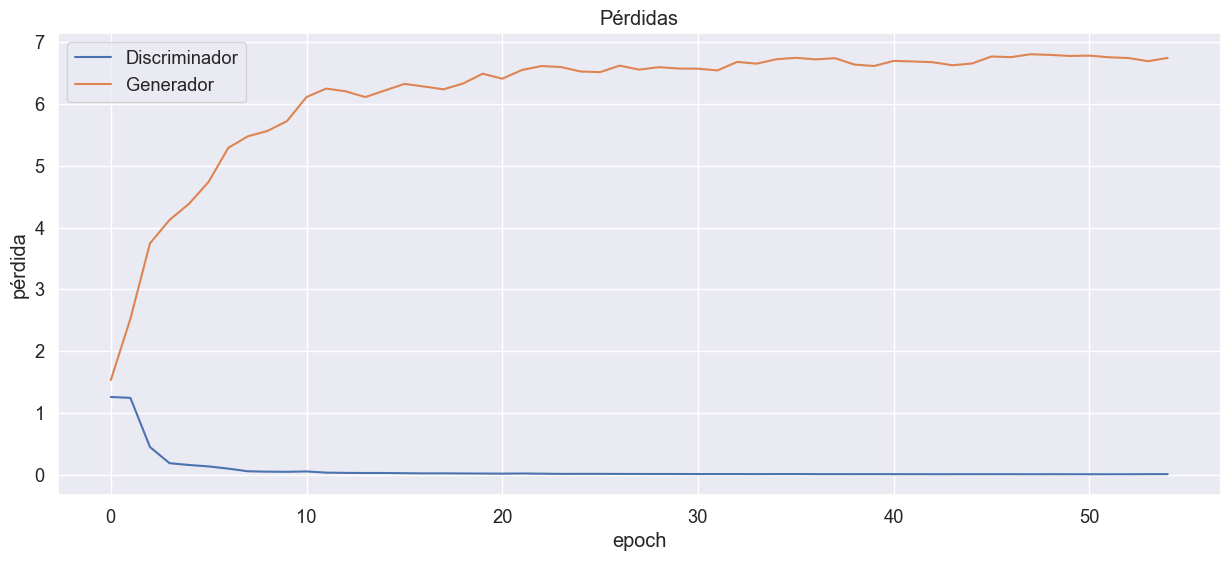

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('pérdida')
plt.legend(['Discriminador', 'Generador'])
plt.title('Pérdidas');

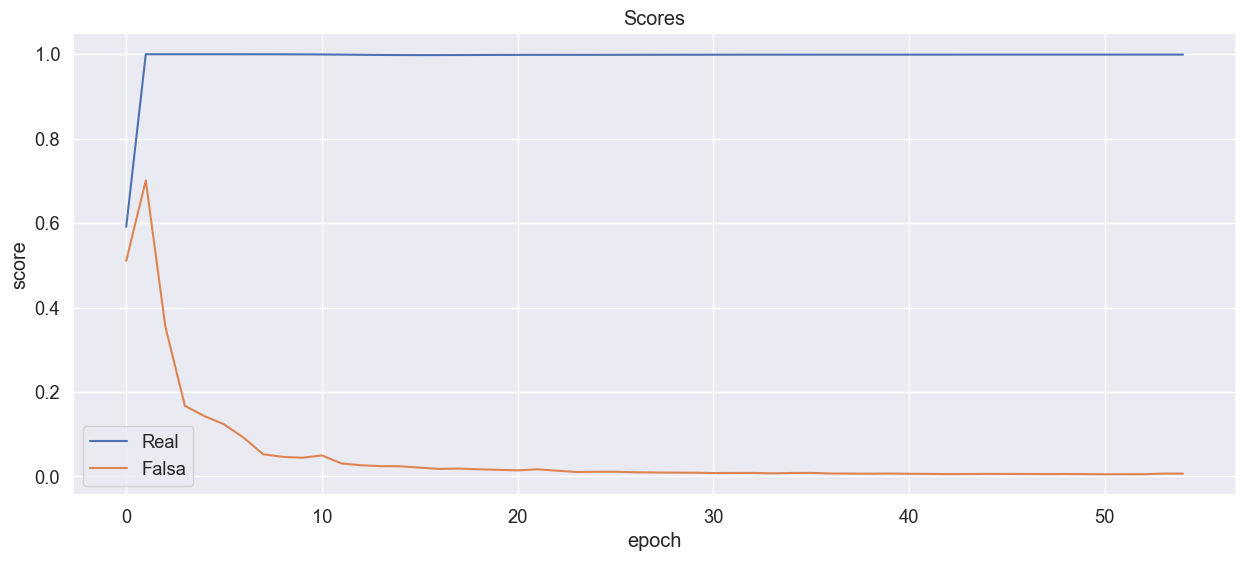

In [32]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Falsa'])
plt.title('Scores');